In [1]:
#batch norm removed, dropout probability to 0.5
#dropout added to fc  not good

#remove vectors after 4096 to be similar to paper, sigmoid is added to each out put, still keep the contrast loss
#modify the net, sigmoid on out put of the outpu1-output2, then get to the 1*1 then,cross entropy

#decided to get the dropout to 0.2, 0.5 not working, kept batch norm, using sigmoid as original paper and droppping the dimensions to 
# 4096 and the 1 with sigmoid and using absolute distance not worked (with BCE losss)

#using contrast loss but kept all 4096 for now as inout to loss,  


#had to go back keep to 4096 to 5 (need definitely batch norm), question put dropout in fc? margin impact now with 2.0

#margin 5 or 1 did not work out just running it longer 200 epochs

#added dropout (0.2) for fc not bad, does it need more than 200 or higher dropout probability?
# test loader option with a flag is added to get if needed same probability of classes as second image or accuracy calculation
#model is also saved
import numpy as np
import torch
from torch import nn
import torch.functional as F
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms,utils, models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
from PIL import Image

In [2]:
test=[]
test2=[]
for i in range(1000):
    test.append(np.random.randint(2))
    test2.append(np.random.randint(0,1))


In [3]:
np.mean(test)

0.51400000000000001

In [4]:
np.mean(test2)

0.0

In [5]:

class att_dataset(Dataset):
    
    def __init__(self,main_dir,data_transorm,flag_train):
        
        #self.train_dir=main_dir+'train/'
        #self.test_dir=main_dir+'test/'
        self.main_dir_=main_dir
        self.data_transform=data_transorm
        self.flag_train=flag_train

        #self.trainset = datasets.ImageFolder(self.train_dir, transform=data_transform)
        self.mainset = datasets.ImageFolder(self.main_dir_)
        self.len=len(list(self.mainset.imgs))   #self.trainset.imgs gives tuples
        self.classes=list(self.mainset.classes)
        self.len_classes=len(self.classes)
        #print(len(self.classes))
        
        #testset = datasets.ImageFolder(self.test_dir, transform=data_transform)

                      
    def __getitem__(self,index):
        
        indx1 = np.random.choice(len(self.mainset.imgs))
        img1=self.mainset.imgs[indx1]  #tuple first image
        #print(img1)
        
        
        #make 50% 
        if(self.flag_train):
            

            random_gen=np.random.randint(2)

            while True:   

                index2 = np.random.choice(len(self.mainset.imgs))
                img2=self.mainset.imgs[index2]

                if ((img1[1]==img2[1]) and (random_gen==1)):   #label checking
                    indx2=index2
                    img2=img2

                    break

                if ((img1[1]!=img2[1]) and (random_gen==0)):   #label checking
                    indx2=index2
                    img2=img2

                    break 
                    
        else:
            
            random_gen_class=np.random.choice(len(self.mainset.imgs))
            img2=self.mainset.imgs[random_gen_class]   #want to make sure if pick 1st image for testing 2nd image coming from random classes
            if((img1[1]!=img2[1])): 
                random_gen=0
            else: 
                random_gen=1
            
            
                
        img0_ = Image.open(img1[0])
        img1_ = Image.open(img2[0])
        
        #img0_ = self.data_transform(img0_)
        #img1_ = self.data_transform(img1_)
            
                
        return F.to_tensor(img0_,img1_,torch.from_numpy(np.array([random_gen],dtype=np.float32))
                  
    
    def __len__(self):
                       
        return self.len
    
    

                                                
                                                
# TODO: Using the image datasets and the trainforms, define the dataloaders


#test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)     

In [12]:
for i in range(10):
    print(np.random.choice(10))

0
2
2
2
3
3
6
4
4
8


In [13]:
main_dir='att_faces/train/'
#train_dir=main_dir+'train/'
#test_dir=main_dir+'test/'
batch_size=10

data_transform_train = transforms.Compose([transforms.Resize(112),transforms.RandomRotation([-30,30]),
        transforms.CenterCrop(105),transforms.RandomHorizontalFlip(),
        transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))
dataset_att=att_dataset(main_dir='att_faces/train/',data_transorm=data_transform_train,flag_train=True)
train_loader = torch.utils.data.DataLoader(dataset_att, batch_size=batch_size,shuffle=True)

data_transform_test = transforms.Compose([transforms.Resize(112),
        transforms.CenterCrop(105),
        transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))
dataset_att2=att_dataset(main_dir='att_faces/test/',data_transorm=data_transform_test,flag_train=False)
test_loader = torch.utils.data.DataLoader(dataset_att2, batch_size=batch_size,shuffle=True)

In [14]:
# main_dir='att_faces/train/'
# #train_dir=main_dir+'train/'
# #test_dir=main_dir+'test/'
# batch_size=10

# data_transform_train = transforms.Compose([transforms.Resize(112),transforms.RandomRotation([-30,30]),
#         transforms.CenterCrop(105),transforms.RandomHorizontalFlip(),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))

# data_transform_test = transforms.Compose([transforms.Resize(112),
#         transforms.CenterCrop(105),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))
# dataset_att=att_dataset(main_dir='att_faces/train/',data_transorm=data_transform_train)
# train_loader = torch.utils.data.DataLoader(dataset_att, batch_size=batch_size,shuffle=True)
# dataset_att2=att_dataset(main_dir='att_faces/test/',data_transorm=data_transform_test)
# test_loader = torch.utils.data.DataLoader(dataset_att2, batch_size=batch_size,shuffle=True)

In [15]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

('att_faces/train/s2/10.pgm', 11)
('att_faces/train/s33/7.pgm', 26)
('att_faces/train/s16/5.pgm', 7)
('att_faces/train/s12/4.pgm', 3)
('att_faces/train/s27/10.pgm', 19)
('att_faces/train/s12/1.pgm', 3)
('att_faces/train/s17/9.pgm', 8)
('att_faces/train/s30/9.pgm', 23)
('att_faces/train/s2/9.pgm', 11)
('att_faces/train/s9/10.pgm', 33)


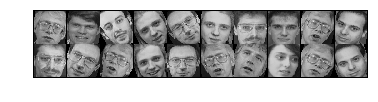

[[ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]]


In [10]:
example_batch = next(iter(train_loader))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=batch_size))
print(example_batch[2].numpy())
#plt.imshow(example_batch[0])



('att_faces/test/s32\\4.pgm', 1)
('att_faces/test/s34\\7.pgm', 3)
('att_faces/test/s33\\9.pgm', 2)
('att_faces/test/s32\\1.pgm', 1)
('att_faces/test/s35\\8.pgm', 4)
('att_faces/test/s34\\1.pgm', 3)
('att_faces/test/s32\\2.pgm', 1)
('att_faces/test/s35\\1.pgm', 4)
('att_faces/test/s34\\4.pgm', 3)
('att_faces/test/s35\\9.pgm', 4)


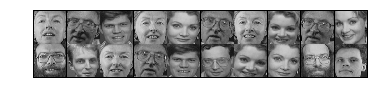

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [88]:
example_batch = next(iter(test_loader))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=batch_size))
print(example_batch[2].numpy())

In [10]:
# image,label=next(iter(train_loader))
# print(image.size())
# print(label.size())
# for i in range(5):
    
#     plt.imshow(image[i][0])
#     plt.show

In [16]:
class simese_network(nn.Module):
    def __init__(self):
        super(simese_network,self).__init__()
        
        self.conv1=nn.Conv2d(1,64,kernel_size=10)   # (105-10-0)/1 +1=96     96*96*64 
        self.relu1=nn.ReLU()                        #                        96*96*64
        self.maxpool1=nn.MaxPool2d(kernel_size=2)   #                        48*48 *64
        self.batchnorm1=nn.BatchNorm2d(64)
        self.dropout1=nn.Dropout2d(p=0.2)
        
        self.conv2=nn.Conv2d(64,128,kernel_size=7)  #  (48-7-0)/1+1= 42     42*42*128
        self.relu2=nn.ReLU()                        #                       42*42*128
        self.maxpool2=nn.MaxPool2d(kernel_size=2)   #                       21*21*128
        self.batchnorm2=nn.BatchNorm2d(128)
        self.dropout2=nn.Dropout2d(p=0.2)
        
        self.conv3=nn.Conv2d(128,128,kernel_size=4) # (21-4-0)/1+1= 18     18*18*128
        self.relu3=nn.ReLU()                        #                      18*18*128
        self.maxpool3=nn.MaxPool2d(kernel_size=2)   #                      9*9*128
        self.batchnorm3=nn.BatchNorm2d(128)
        self.dropout3=nn.Dropout2d(p=0.2)
        
        self.conv4=nn.Conv2d(128,256,kernel_size=4) # (9-4-0)/1+1=6       6*6*256 
        self.relu4=nn.ReLU() 
        self.batchnorm4=nn.BatchNorm2d(256)
        self.dropout4=nn.Dropout2d(p=0.2)
        
        self.linear1=nn.Linear(9216,4096)  ##self.linear2=nn.Linear(4096,1)    
        self.relu5=nn.ReLU()
        self.dropout5=nn.Dropout(p=0.2)
        
        self.linear2=nn.Linear(4096,512)
        self.relu6=nn.ReLU()
        self.dropout6=nn.Dropout(p=0.2)
        
        self.linear3=nn.Linear(512,10)
        self.relu7=nn.ReLU()  
        self.dropout7=nn.Dropout(p=0.2)
        
        self.linear4=nn.Linear(10,5)       
        
        
        

    def forward_main(self,x):
        
        self.in_channel_batch=x.size(0)
        
        x=self.dropout1(self.batchnorm1(self.maxpool1(self.relu1(self.conv1(x)))))
              
        x=self.dropout2(self.batchnorm2(self.maxpool2(self.relu2(self.conv2(x)))))
        
        x=self.dropout3(self.batchnorm3(self.maxpool3(self.relu3(self.conv3(x)))))
        
        x=self.dropout4(self.batchnorm4(self.relu4(self.conv4(x))))
        
        x=x.view(self.in_channel_batch,-1)  #batch batch size* -1,  
        
        
        #x=self.linear1(x)
        
        x=self.dropout5(self.relu5(self.linear1(x)))
        x=self.dropout6(self.relu6(self.linear2(x)))       
        x=self.dropout7(self.relu7(self.linear3(x)))
        
        x=self.linear4(x)
        
        #output=F.sigmoid(x)
        
        output=x
        
        return output
    
    
    def forward(self,x1,x2):
        
        output1=self.forward_main(x1)
        output2=self.forward_main(x2)
        
        #xx=((F.pairwise_distance(output1,output2,p=1,keepdim=False)))  #it seemd to be more stable to use logit loss that does sigmoid inside it, than BCE loss with sigmoid done in forward
        #xx=xx.view(self.in_channel_batch,-1)
        #xx=torch.FloatTensor.abs(output1-output2)
        #xx=self.linear2(xx)
        #output_=F.sigmoid(xx)
        
        return output1,output2
        
    
    
    

In [17]:

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


In [18]:
model=simese_network()

In [19]:
epochs=500
criterion=ContrastiveLoss()  
#criterion=torch.nn.BCEWithLogitsLoss(size_average=True)
#criterion=torch.nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0005)  #had to change from SGD to Adam but later noy much difference

lr_scheduler_=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lr_scheduler_=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [20]:
within_run_loss=[]
step_=[]
avg_loss_=[]
def train_function(train_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0
    
    model.to(device)

    for epoch in range(epochs):

        for step,(img1,img2,labels) in enumerate(train_loader):
            
            
            
            img1=img1.to(device)
            img2=img2.to(device)
            labels=labels.to(device)
            #print(labels)
            optimizer.zero_grad()
            #input.resize_(input.size()[0], 784)   take to forward
            output1,output2=model(img1,img2)   #this is 64 (bacth_size)*10
            
            #if(count==0): print(y_pred.size(),labels.size())
            loss=criterion(output1,output2,labels)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            
            loss.backward()
            optimizer.step()
            count=count+1
            #y_pred_round=torch.round(y_pred)
            count_batch=count_batch+(labels.size()[0])
            #_,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            #acc=(labels==y_pred_).sum().item()    #/label.size()[0]
            #sum_acc=sum_acc+acc
            #print(count)
            if(step%500==0): 
                
                print('epoch',epoch+1,'/',epochs,'avg train running_loss:',(loss_running/count_batch),'within run loss',loss.item())  #,'Accuracy',(sum_acc*100/count_batch))
                within_run_loss.append(loss.item())
                #step_=[]
                avg_loss_.append(loss_running/count_batch)
                print('-----')
                #test_function(test_loader)
                #print('---------------------')
                #model.train()
            
        check_loss=(loss_running/count_batch)
        lr_scheduler_.step(check_loss)



In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_function(train_loader)

cuda
epoch 1 / 500 avg train running_loss: 0.18440185785293578 within run loss 1.844018578529358
-----
epoch 2 / 500 avg train running_loss: 0.1350220911843436 within run loss 1.1234781742095947
-----
epoch 3 / 500 avg train running_loss: 0.13320726622705875 within run loss 1.7680630683898926
-----
epoch 4 / 500 avg train running_loss: 0.1314389264120639 within run loss 1.389070749282837
-----
epoch 5 / 500 avg train running_loss: 0.1294093014550035 within run loss 1.0337127447128296
-----
epoch 6 / 500 avg train running_loss: 0.12731821725243017 within run loss 1.0820724964141846
-----
epoch 7 / 500 avg train running_loss: 0.12559829083884635 within run loss 1.3835959434509277
-----
epoch 8 / 500 avg train running_loss: 0.12537910945744693 within run loss 1.257423758506775
-----
epoch 9 / 500 avg train running_loss: 0.12402943460059253 within run loss 1.1014604568481445
-----
epoch 10 / 500 avg train running_loss: 0.12331161842672367 within run loss 1.1294630765914917
-----
epoch 11 /

epoch 84 / 500 avg train running_loss: 0.1140707232556865 within run loss 1.0713837146759033
-----
epoch 85 / 500 avg train running_loss: 0.11405095452815034 within run loss 1.035036325454712
-----
epoch 86 / 500 avg train running_loss: 0.11399642601222655 within run loss 1.0232106447219849
-----
epoch 87 / 500 avg train running_loss: 0.11398548176145962 within run loss 1.2757090330123901
-----
epoch 88 / 500 avg train running_loss: 0.11396106016237054 within run loss 1.1664316654205322
-----
epoch 89 / 500 avg train running_loss: 0.1138987290691939 within run loss 1.0541917085647583
-----
epoch 90 / 500 avg train running_loss: 0.11387575894919094 within run loss 1.147764801979065
-----
epoch 91 / 500 avg train running_loss: 0.113822581613426 within run loss 0.9111984968185425
-----
epoch 92 / 500 avg train running_loss: 0.11379915037524913 within run loss 1.1251400709152222
-----
epoch 93 / 500 avg train running_loss: 0.11374855616024868 within run loss 1.2118960618972778
-----
epoch 

epoch 166 / 500 avg train running_loss: 0.11213141943103509 within run loss 1.0412163734436035
-----
epoch 167 / 500 avg train running_loss: 0.11211039928021528 within run loss 1.0232261419296265
-----
epoch 168 / 500 avg train running_loss: 0.11208278702417505 within run loss 1.0172256231307983
-----
epoch 169 / 500 avg train running_loss: 0.11205094657719668 within run loss 1.05118989944458
-----
epoch 170 / 500 avg train running_loss: 0.11202110138087971 within run loss 1.0943478345870972
-----
epoch 171 / 500 avg train running_loss: 0.111998878489768 within run loss 0.9613937139511108
-----
epoch 172 / 500 avg train running_loss: 0.11197877532945864 within run loss 1.239404320716858
-----
epoch 173 / 500 avg train running_loss: 0.11195148279227075 within run loss 1.0000206232070923
-----
epoch 174 / 500 avg train running_loss: 0.11193151226887467 within run loss 1.1638901233673096
-----
epoch 175 / 500 avg train running_loss: 0.11190880437406592 within run loss 1.1083513498306274
-

epoch 248 / 500 avg train running_loss: 0.11064019204889228 within run loss 0.90547776222229
-----
epoch 249 / 500 avg train running_loss: 0.11063453624868512 within run loss 1.127753734588623
-----
epoch 250 / 500 avg train running_loss: 0.11061395860498315 within run loss 0.9050354957580566
-----
epoch 251 / 500 avg train running_loss: 0.11060545816447873 within run loss 1.1544705629348755
-----
epoch 252 / 500 avg train running_loss: 0.11060003717321364 within run loss 1.010648488998413
-----
epoch 253 / 500 avg train running_loss: 0.1105943648605645 within run loss 0.9983525276184082
-----
epoch 254 / 500 avg train running_loss: 0.11058691293780615 within run loss 1.3166000843048096
-----
epoch 255 / 500 avg train running_loss: 0.1105709608967304 within run loss 0.9925010204315186
-----
epoch 256 / 500 avg train running_loss: 0.11056221381230223 within run loss 1.0824790000915527
-----
epoch 257 / 500 avg train running_loss: 0.11055173402678892 within run loss 0.9906744360923767
--

epoch 330 / 500 avg train running_loss: 0.10981835921818549 within run loss 1.063527226448059
-----
epoch 331 / 500 avg train running_loss: 0.10980908207561485 within run loss 1.1109617948532104
-----
epoch 332 / 500 avg train running_loss: 0.10980862465396239 within run loss 1.1447871923446655
-----
epoch 333 / 500 avg train running_loss: 0.10980466415160033 within run loss 1.105057954788208
-----
epoch 334 / 500 avg train running_loss: 0.10979778005979322 within run loss 1.0414620637893677
-----
epoch 335 / 500 avg train running_loss: 0.10979221662900246 within run loss 1.098222255706787
-----
epoch 336 / 500 avg train running_loss: 0.10977952346623011 within run loss 1.0941394567489624
-----
epoch 337 / 500 avg train running_loss: 0.10977320057662363 within run loss 1.327040672302246
-----
epoch 338 / 500 avg train running_loss: 0.10976887696471158 within run loss 1.1328479051589966
-----
epoch 339 / 500 avg train running_loss: 0.10976091670137383 within run loss 1.0965741872787476


epoch 412 / 500 avg train running_loss: 0.10934116648987922 within run loss 1.1385387182235718
-----
epoch 413 / 500 avg train running_loss: 0.10933344114413054 within run loss 1.043141484260559
-----
epoch 414 / 500 avg train running_loss: 0.10933088232952586 within run loss 1.1164631843566895
-----
epoch 415 / 500 avg train running_loss: 0.10932436452726922 within run loss 1.0327556133270264
-----
epoch 416 / 500 avg train running_loss: 0.10931698311254648 within run loss 1.241612195968628
-----
epoch 417 / 500 avg train running_loss: 0.10931283828857384 within run loss 1.0277819633483887
-----
epoch 418 / 500 avg train running_loss: 0.10930128595970087 within run loss 0.9999311566352844
-----
epoch 419 / 500 avg train running_loss: 0.10929227610246005 within run loss 1.036757230758667
-----
epoch 420 / 500 avg train running_loss: 0.10928541967439896 within run loss 0.9544289112091064
-----
epoch 421 / 500 avg train running_loss: 0.10927673624173057 within run loss 1.132081389427185


epoch 494 / 500 avg train running_loss: 0.10902607759150458 within run loss 1.042497158050537
-----
epoch 495 / 500 avg train running_loss: 0.1090203518557919 within run loss 1.0181154012680054
-----
epoch 496 / 500 avg train running_loss: 0.10901844527524364 within run loss 0.9465725421905518
-----
epoch 497 / 500 avg train running_loss: 0.10901602102357981 within run loss 1.0904784202575684
-----
epoch 498 / 500 avg train running_loss: 0.10901508606307654 within run loss 1.027246117591858
-----
epoch 499 / 500 avg train running_loss: 0.10901443483078606 within run loss 0.9698268175125122
-----
epoch 500 / 500 avg train running_loss: 0.10901118257699581 within run loss 1.0489652156829834
-----


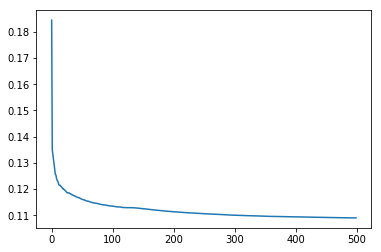

In [22]:
plt.plot(avg_loss_)

In [38]:
path_='att_faces_500_mod6.pth'
torch.save(model.state_dict(), path_)

In [ ]:
model.load_state_dict(torch.load('att_faces_500_mod6.pth'))

In [30]:

batch_size=1

# data_transform = transforms.Compose([transforms.Resize(112),
#         transforms.CenterCrop(105),
#         transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))


dataset_att=att_dataset(main_dir='att_faces/train/',data_transorm=data_transform_test,flag_train=True)
train_loader = torch.utils.data.DataLoader(dataset_att, batch_size=batch_size,shuffle=True)

dataset_att2=att_dataset(main_dir='att_faces/test/',data_transorm=data_transform_test,flag_train=True)
test_loader = torch.utils.data.DataLoader(dataset_att2, batch_size=batch_size,shuffle=True)

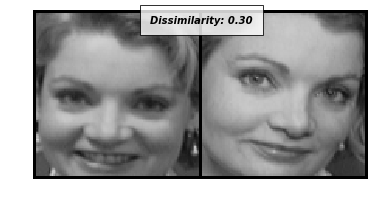

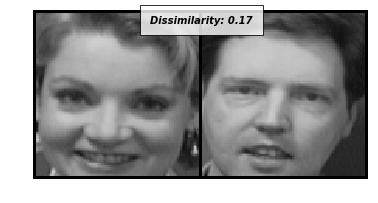

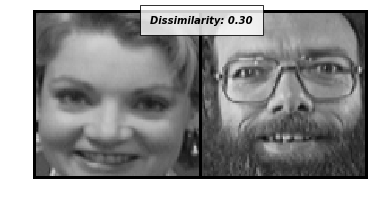

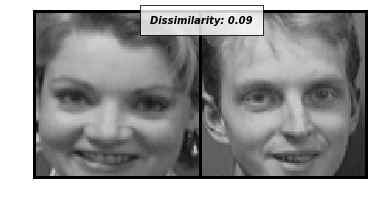

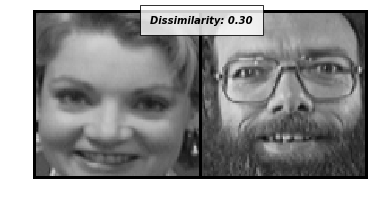

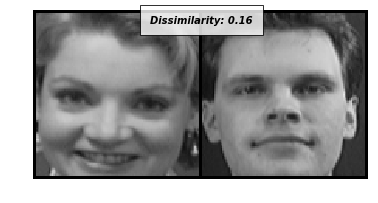

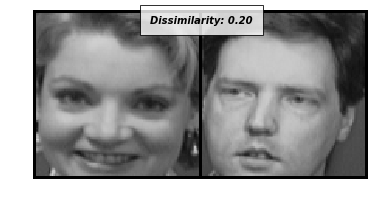

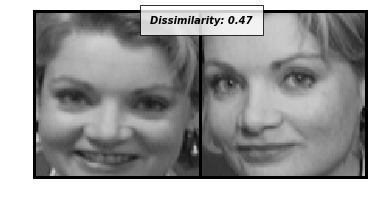

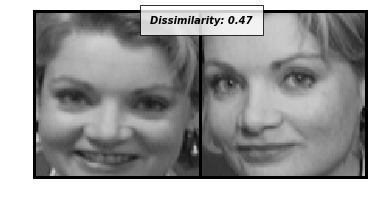

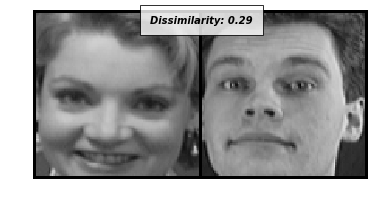

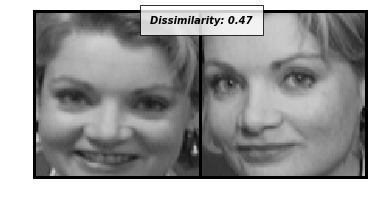

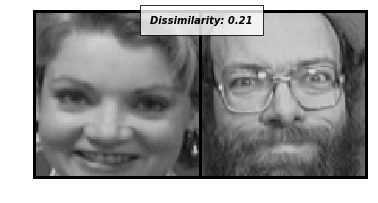

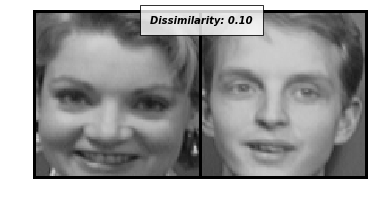

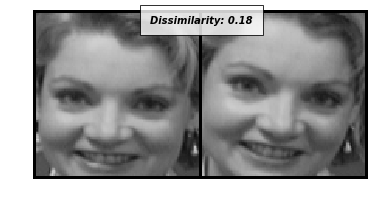

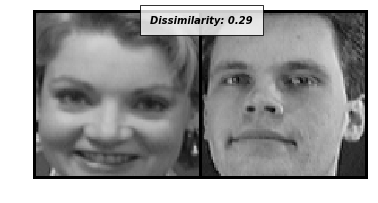

In [31]:

dataiter = iter(test_loader)
img1,_,_ = next(dataiter)

#for step,(img1,img2,labels) in enumerate(train_loader):
with torch.no_grad():    
    for i in range(15):

        _,img2,labels = next(dataiter)

        model.eval()
        img1=img1.to(device)
        img2=img2.to(device)

        concatenated = torch.cat((img1,img2),0)
        #img1=img1.to(device)
        #img2=img2.to(device)
        labels=labels.to(device)

        output1,output2=model(img1,img2)   
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss=criterion(output1,output2,labels)    
        imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

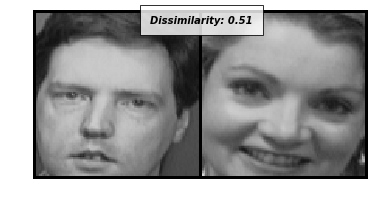

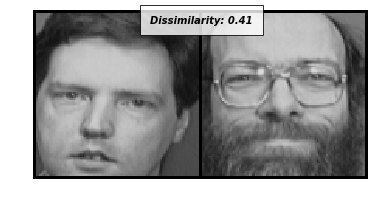

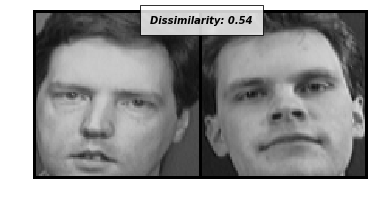

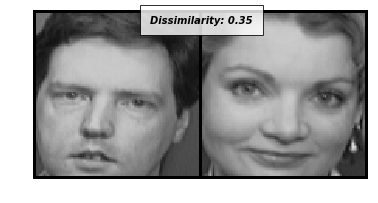

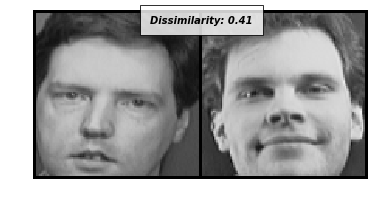

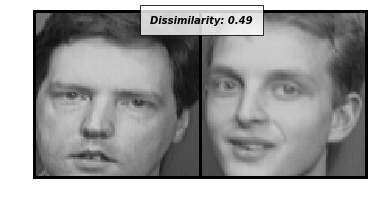

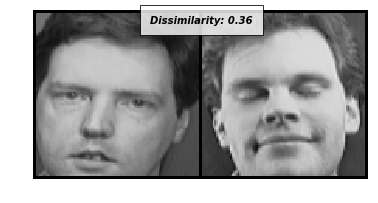

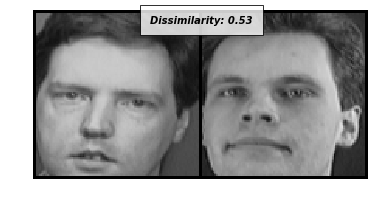

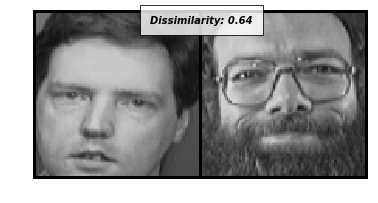

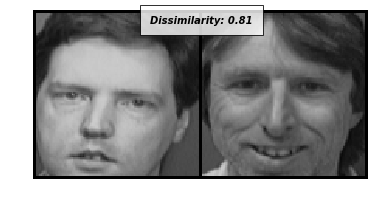

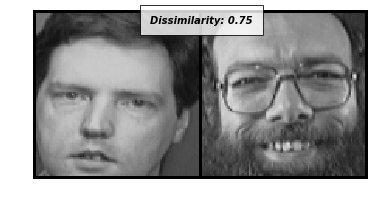

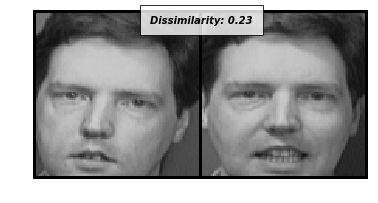

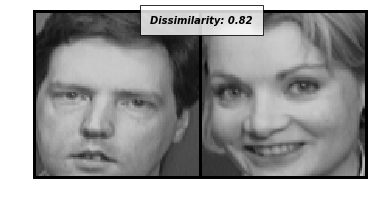

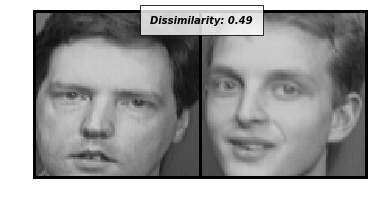

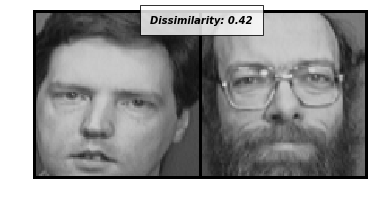

In [33]:

dataiter = iter(test_loader)
img1,_,_ = next(dataiter)

#for step,(img1,img2,labels) in enumerate(train_loader):
with torch.no_grad():    
    for i in range(15):

        _,img2,labels = next(dataiter)

        model.eval()
        img1=img1.to(device)
        img2=img2.to(device)

        concatenated = torch.cat((img1,img2),0)
        #img1=img1.to(device)
        #img2=img2.to(device)
        labels=labels.to(device)

        output1,output2=model(img1,img2)   
        euclidean_distance = F.pairwise_distance(output1, output2,p=1)
        loss=criterion(output1,output2,labels)    
        imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [36]:
count=0
countj=0

for j in range(50):
    countj=countj+1
    print('--------------------------')
    dataiter = iter(train_loader)
    img1,_,_ = next(dataiter)
    distance_init=100.0
    label_save=None

    #for step,(img1,img2,labels) in enumerate(train_loader):
    with torch.no_grad():    
        for i in range(50):

            _,img2,labels = next(dataiter)

            model.eval()
            img1=img1.to(device)
            img2=img2.to(device)

            concatenated = torch.cat((img1,img2),0)
            #img1=img1.to(device)
            #img2=img2.to(device)
            labels=labels.to(device)

            output1,output2=model(img1,img2)   
            euclidean_distance = F.pairwise_distance(output1, output2)
            loss=criterion(output1,output2,labels)
            if(euclidean_distance<distance_init): 
                distance_init=euclidean_distance
                label_save=labels.item()
                
               
            #imshow(torchvision.utils.make_grid(concatenated.cpu()),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
        if(label_save==1): count=count+1
            
print(count*100./countj)            

--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
--------------------------
-